# Vanilla

In [1]:
using Pkg # to get around DiffEqOperators bug that Chris just fixed
pkg"activate" # I've dev'ed DiffEqOperators in my main environment

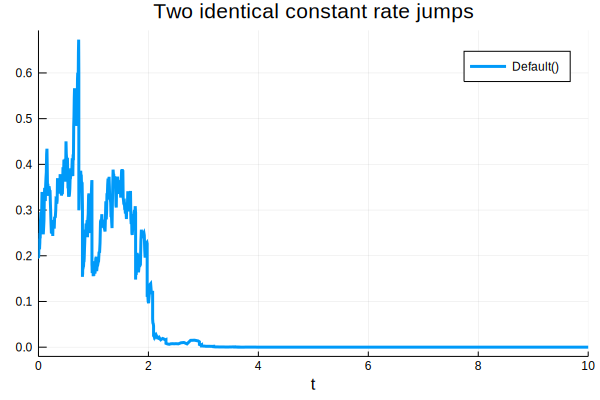

In [2]:
# Code from Pooya
using DifferentialEquations, StochasticDiffEq, DiffEqJump, Plots

struct AffectIndex{F1, F2}
    affect_index!::F1
    index::F2
  end

function (p::AffectIndex)(integrator)
      return p.affect_index!(integrator, p.index)
end
  
function f(du,u,p,t)
    du[1] = u[1]
end
  
function g(du,u,p,t)
    du[1] = u[1]
end
iv = [0.2]
prob = SDEProblem(f,g,iv,(0.0,10.0))

rate(u,p,t) = 2
affect_index!(integrator, index) = (integrator.u[index] = integrator.u[index]/2 )
#(integrator.u[index] = integrator.u[index]/2)
jumps = [ConstantRateJump(rate,AffectIndex(affect_index!, 1)) for i in 1:2 ]
jump_prob = JumpProblem(prob,Direct(),JumpSet((), jumps, nothing, nothing))

#comapring different methods of solving
sol_o = solve(jump_prob)
p1 = plot(sol_o, label = "Default()", title= "Two identical constant rate jumps")

# With Callback

In [3]:
using StatsBase, DataFrames

In [69]:
function solution_summary(u, t, integrator)
    summ = summarystats(u)

    # should hav a special case that if at first time-step, then make `g = 0` or something like that.
    if t ≈ 0. 
        g = 0.
    else
        prevmean = saved_values.saveval[end].mean 
        prevt = saved_values.t[end-1]
        g_val = (summ.mean - prevmean)/(t - prevt) # already in logs, so just need the slow.
        g = (g_val < Inf && g_val > -Inf) ? g_val : 0.
    end
            
    values = (g = g, t = t, mean = summ.mean, max = summ.max, min = summ.min, median = summ.median, q25 = summ.q25, q75 = summ.q75)
    return values
end

solution_summary (generic function with 1 method)

In [70]:
saved_values = SavedValues(Float64, NamedTuple{(:g, :t, :mean, :max, :min, :median, :q25, :q75),NTuple{8,Float64}}) # or a named tuple?
saveat_range = 0.0:0.01:10.0
cb = SavingCallback(solution_summary, saved_values, saveat = saveat_range);

In [71]:
sol_cb = solve(jump_prob, callback = cb);

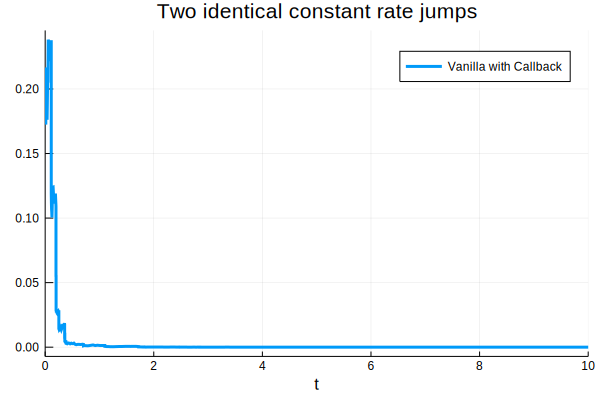

In [72]:
plot(sol_cb, label = "Vanilla with Callback", title= "Two identical constant rate jumps")

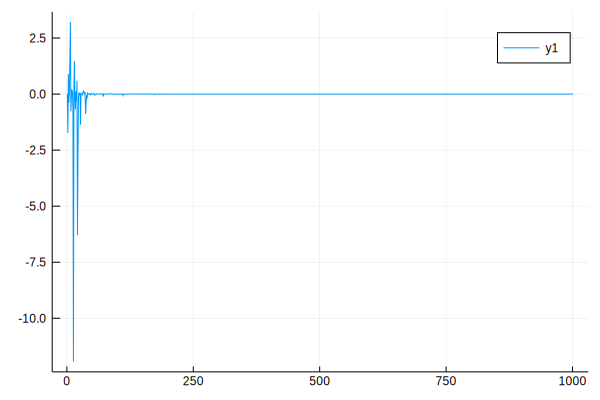

In [73]:
gs = (x -> x.g).(saved_values.saveval);
plot(gs)